In [96]:
import pandas as pd
import prophet
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

In [97]:
df = pd.read_csv('products.csv')
# drop NoPromo_Units NoPromo_Dollars IncUnits IncDollars
df = df.drop(['NoPromo_Units', 'NoPromo_Dollars', 'IncUnits', 'IncDollars', 'GLMarket'], axis=1)
# remove w in GLPeriod values
df['GLPeriod'] = df['GLPeriod'].str.replace('w', '')
df['GLPeriod'] = pd.to_datetime(df['GLPeriod'], format='%Y%m%d')
df.dropna(inplace=True)
df = df.rename(columns={'GLPeriod': 'Date'})
df.head()
 

,UPC,Date,Dollars,BaseDollars,Units,Base_Units,AnyPromo_Dollars,AnyPromo_Units
0,89231600047,2019-01-05,0.00,3.84,0.0,0.148,0.0,0.0
1,9950010526,2019-01-19,0.00,0.66,0.0,0.349,0.0,0.0
2,7780253340,2019-01-26,0.00,0.23,0.0,0.120,0.0,0.0
3,6197200193,2019-02-16,0.00,1.63,0.0,1.054,0.0,0.0
4,7780234935,2019-02-16,0.59,0.30,1.0,0.512,0.0,0.0


In [98]:
print(df['UPC'].value_counts())
df.head()

UPC
7124929046      170
360734538038    170
5233690968      170
76180900572     170
7124905912      170
               ... 
3098503800        1
7124916003        1
7124916147        1
7476462014        1
7124923332        1
Name: count, Length: 50445, dtype: int64


,UPC,Date,Dollars,BaseDollars,Units,Base_Units,AnyPromo_Dollars,AnyPromo_Units
0,89231600047,2019-01-05,0.00,3.84,0.0,0.148,0.0,0.0
1,9950010526,2019-01-19,0.00,0.66,0.0,0.349,0.0,0.0
2,7780253340,2019-01-26,0.00,0.23,0.0,0.120,0.0,0.0
3,6197200193,2019-02-16,0.00,1.63,0.0,1.054,0.0,0.0
4,7780234935,2019-02-16,0.59,0.30,1.0,0.512,0.0,0.0


In [99]:
df.tail()

,UPC,Date,Dollars,BaseDollars,Units,Base_Units,AnyPromo_Dollars,AnyPromo_Units
3406358,78804106006,2017-12-02,0.0,1.37,0.0,0.250,0.0,0.0
3406359,80030779073,2017-09-23,0.0,1.47,0.0,0.178,0.0,0.0
3406360,2781103204,2017-09-30,0.0,0.00,0.0,0.002,0.0,0.0
3406361,9017443938,2017-08-05,0.0,0.49,0.0,0.038,0.0,0.0
3406362,81903701110,2017-09-23,0.0,6.44,0.0,0.671,0.0,0.0


In [100]:
df['AnyPromo_Dollars'].value_counts()

AnyPromo_Dollars
0.000        1958795
0.010            349
1.990            326
4.990            317
3.990            316
              ...   
3034.230           1
2002.061           1
829.150            1
12338.144          1
3567.654           1
Name: count, Length: 956802, dtype: int64

In [111]:
# only keep if UPC is 7124929046
# AnyPromo_Dollars + INCdollars + BaseDollars = Dollars

df_copy = df[df['UPC'] == 7124929046]
# sort on date
df_copy = df_copy.sort_values(by=['Date'])
# reset index
df_copy = df_copy.reset_index(drop=True)
print(df_copy.shape)
df_copy
# max basedollars
max_base_dollars = df_copy['BaseDollars'].max()
max_base_dollars    

(170, 8)


3748.1

In [102]:
from prophet import Prophet
import pandas as pd

# Assuming your dataframe is named 'df'
# Renaming columns as Prophet requires specific column names
df_copy = df_copy.rename(columns={'Date': 'ds', 'BaseDollars': 'y'})
# normalize data
df_copy['y'] = df_copy['y'] / df_copy['y'].max()



train_data = df_copy[:int(0.8*(len(df_copy)))]
test_data = df_copy[int(0.8*(len(df_copy))):]
validation_data = train_data[int(0.8*(len(train_data))):]

In [103]:
from prophet import Prophet
from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import mean_squared_error
# Define the search space
space = {
    'changepoint_prior_scale': hp.uniform('changepoint_prior_scale', 0.001, 1),
    'seasonality_prior_scale': hp.uniform('seasonality_prior_scale', 0.01, 10.0),
    'holidays_prior_scale': hp.uniform('holidays_prior_scale', 0.01, 10.0),
    'changepoint_range': hp.uniform('changepoint_range', 0.6, 0.95),
    'yearly_seasonality': hp.choice('yearly_seasonality', [True, False]),
    'weekly_seasonality': hp.choice('weekly_seasonality', [True, False]),
    'daily_seasonality': hp.choice('daily_seasonality', [True, False]),
}
def objective(params):
    model = Prophet(**params)
    model.fit(train_data)
    forecast = model.predict(validation_data)  
    validation_target = validation_data['y']
    error = mean_squared_error(validation_target, forecast['yhat'])
    return error

# Perform optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2000, trials=trials)

print("Best hyperparameters:", best)



  0%|          | 0/2000 [00:00<?, ?trial/s, best loss=?]

  2%|▏         | 32/2000 [00:06<06:09,  5.33trial/s, best loss: 0.0032579358250184797]

10:33:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 15%|█▍        | 293/2000 [00:58<05:27,  5.22trial/s, best loss: 0.0032514370790095613]

10:34:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 33%|███▎      | 651/2000 [02:09<05:31,  4.07trial/s, best loss: 0.003248078217379879] 

10:35:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



 57%|█████▋    | 1140/2000 [03:52<02:57,  4.85trial/s, best loss: 0.0032469221787136504]

10:37:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.



100%|██████████| 2000/2000 [07:02<00:00,  4.73trial/s, best loss: 0.003244367372300687] 
Best hyperparameters: {'changepoint_prior_scale': 0.4996742902840625, 'changepoint_range': 0.7748039189914275, 'daily_seasonality': 1, 'holidays_prior_scale': 2.807370338403507, 'seasonality_prior_scale': 7.468462642742791, 'weekly_seasonality': 0, 'yearly_seasonality': 0}


In [104]:
# retrun back to original column names
from hyperopt import space_eval
best_params = space_eval(space, best)
best_params

{'changepoint_prior_scale': 0.4996742902840625,
 'changepoint_range': 0.7748039189914275,
 'daily_seasonality': False,
 'holidays_prior_scale': 2.807370338403507,
 'seasonality_prior_scale': 7.468462642742791,
 'weekly_seasonality': True,
 'yearly_seasonality': True}

In [105]:
best

{'changepoint_prior_scale': 0.4996742902840625,
 'changepoint_range': 0.7748039189914275,
 'daily_seasonality': 1,
 'holidays_prior_scale': 2.807370338403507,
 'seasonality_prior_scale': 7.468462642742791,
 'weekly_seasonality': 0,
 'yearly_seasonality': 0}

In [106]:
import json
with open('hyperopt normalized.txt', 'w') as f:
    json.dump(best_params, f, indent=4)

tuned params

C:\Users\bartw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\bartw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-14,0.662105,0.589080,0.726516,0.662105,0.662105,-0.003848,-0.003848,-0.003848,-0.050048,-0.050048,-0.050048,0.046200,0.046200,0.046200,0.0,0.0,0.0,0.658257
1,2020-03-21,0.662127,0.536175,0.680343,0.661741,0.662421,-0.057334,-0.057334,-0.057334,-0.050048,-0.050048,-0.050048,-0.007286,-0.007286,-0.007286,0.0,0.0,0.0,0.604794
2,2020-03-28,0.662150,0.503543,0.645067,0.661218,0.662920,-0.087111,-0.087111,-0.087111,-0.050048,-0.050048,-0.050048,-0.037064,-0.037064,-0.037064,0.0,0.0,0.0,0.575039
3,2020-04-04,0.662172,0.513757,0.649893,0.660315,0.663603,-0.077190,-0.077190,-0.077190,-0.050048,-0.050048,-0.050048,-0.027142,-0.027142,-0.027142,0.0,0.0,0.0,0.584982
4,2020-04-11,0.662195,0.540842,0.683642,0.659494,0.664606,-0.052849,-0.052849,-0.052849,-0.050048,-0.050048,-0.050048,-0.002801,-0.002801,-0.002801,0.0,0.0,0.0,0.609346
5,2020-04-18,0.662217,0.540349,0.684316,0.658373,0.665691,-0.047947,-0.047947,-0.047947,-0.050048,-0.050048,-0.050048,0.002101,0.002101,0.002101,0.0,0.0,0.0,0.614270
6,2020-04-25,0.662240,0.518392,0.661740,0.657423,0.666854,-0.070214,-0.070214,-0.070214,-0.050048,-0.050048,-0.050048,-0.020166,-0.020166,-0.020166,0.0,0.0,0.0,0.592026
7,2020-05-02,0.662262,0.492208,0.635124,0.656068,0.668114,-0.100161,-0.100161,-0.100161,-0.050048,-0.050048,-0.050048,-0.050113,-0.050113,-0.050113,0.0,0.0,0.0,0.562101
8,2020-05-09,0.662284,0.472206,0.618200,0.654803,0.669397,-0.116908,-0.116908,-0.116908,-0.050048,-0.050048,-0.050048,-0.066861,-0.066861,-0.066861,0.0,0.0,0.0,0.545376
9,2020-05-16,0.662307,0.470626,0.615743,0.653628,0.670853,-0.117540,-0.117540,-0.117540,-0.050048,-0.050048,-0.050048,-0.067493,-0.067493,-0.067493,0.0,0.0,0.0,0.544767


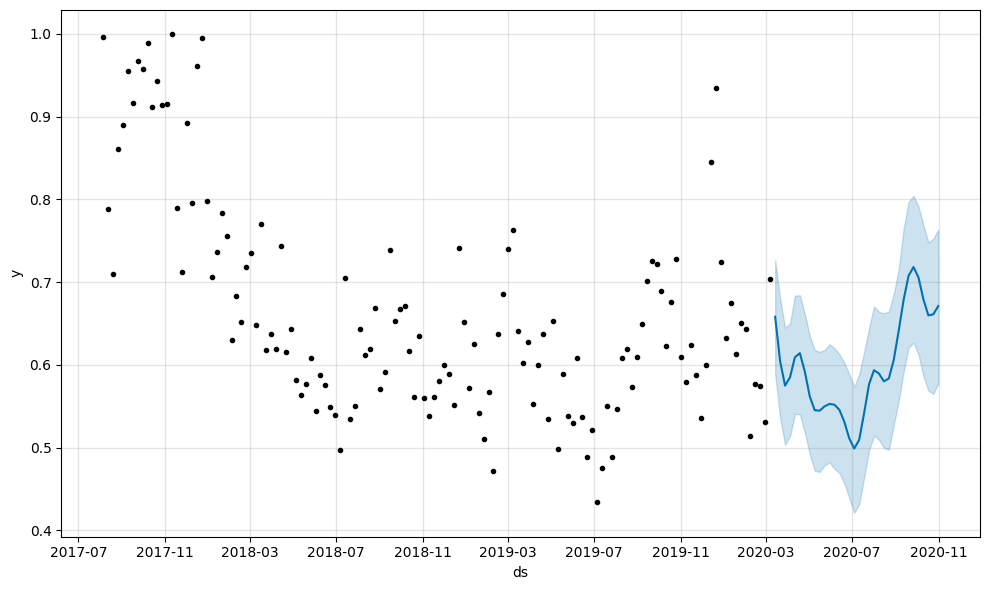

In [107]:
model = Prophet(**best_params)
model.fit(train_data)
forecast = model.predict(test_data)
fig = model.plot(forecast)
forecast

In [112]:
# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from math import sqrt

def metrics_calulation(test_target,yhat, scale=1):
    test_target = test_target * scale
    yhat = yhat * scale
    mse = mean_squared_error(test_target, yhat)
    mae = mean_absolute_error(test_target, yhat)
    r2 = r2_score(test_target, yhat)
    medae = median_absolute_error(test_target, yhat)
    rmse = sqrt(mse)
    print(f"Mean Squared Error: {mse}\nMean Absolute Error: {mae}\nR2 Score: {r2}\nMedian Absolute Error: {medae}\nRoot Mean Squared Error: {rmse}")
    return {'mse':mse,'mae':mae,'r2':r2,'medae':medae,'rmse':rmse}	
# Calculate the metrics
test_target = test_data['y']
yhat = forecast['yhat']
scores = metrics_calulation(test_target,yhat, scale=max_base_dollars)
scores

Mean Squared Error: 1270697.5875432384
Mean Absolute Error: 1070.0181028248935
R2 Score: -12.552277498306806
Median Absolute Error: 1146.7953773628371
Root Mean Squared Error: 1127.2522288925572


{'mse': 1270697.5875432384,
 'mae': 1070.0181028248935,
 'r2': -12.552277498306806,
 'medae': 1146.7953773628371,
 'rmse': 1127.2522288925572}

Non Tuned

C:\Users\bartw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\bartw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-14,0.618592,0.589370,0.738115,0.618592,0.618605,0.041693,0.041693,0.041693,0.041693,0.041693,0.041693,0.0,0.0,0.0,0.660285
1,2020-03-21,0.619090,0.534963,0.679580,0.618991,0.619192,-0.011904,-0.011904,-0.011904,-0.011904,-0.011904,-0.011904,0.0,0.0,0.0,0.607186
2,2020-03-28,0.619588,0.500715,0.658343,0.619347,0.619840,-0.041841,-0.041841,-0.041841,-0.041841,-0.041841,-0.041841,0.0,0.0,0.0,0.577747
3,2020-04-04,0.620086,0.508671,0.665320,0.619609,0.620525,-0.031613,-0.031613,-0.031613,-0.031613,-0.031613,-0.031613,0.0,0.0,0.0,0.588473
4,2020-04-11,0.620584,0.533401,0.689285,0.619843,0.621295,-0.006491,-0.006491,-0.006491,-0.006491,-0.006491,-0.006491,0.0,0.0,0.0,0.614093
5,2020-04-18,0.621082,0.542863,0.698291,0.620011,0.622122,-0.000877,-0.000877,-0.000877,-0.000877,-0.000877,-0.000877,0.0,0.0,0.0,0.620206
6,2020-04-25,0.621580,0.519717,0.669724,0.620196,0.622953,-0.022919,-0.022919,-0.022919,-0.022919,-0.022919,-0.022919,0.0,0.0,0.0,0.598662
7,2020-05-02,0.622078,0.491103,0.643825,0.620248,0.623817,-0.052898,-0.052898,-0.052898,-0.052898,-0.052898,-0.052898,0.0,0.0,0.0,0.569181
8,2020-05-09,0.622577,0.477838,0.626325,0.620331,0.624727,-0.069364,-0.069364,-0.069364,-0.069364,-0.069364,-0.069364,0.0,0.0,0.0,0.553213
9,2020-05-16,0.623075,0.476795,0.630448,0.620340,0.625664,-0.069271,-0.069271,-0.069271,-0.069271,-0.069271,-0.069271,0.0,0.0,0.0,0.553804


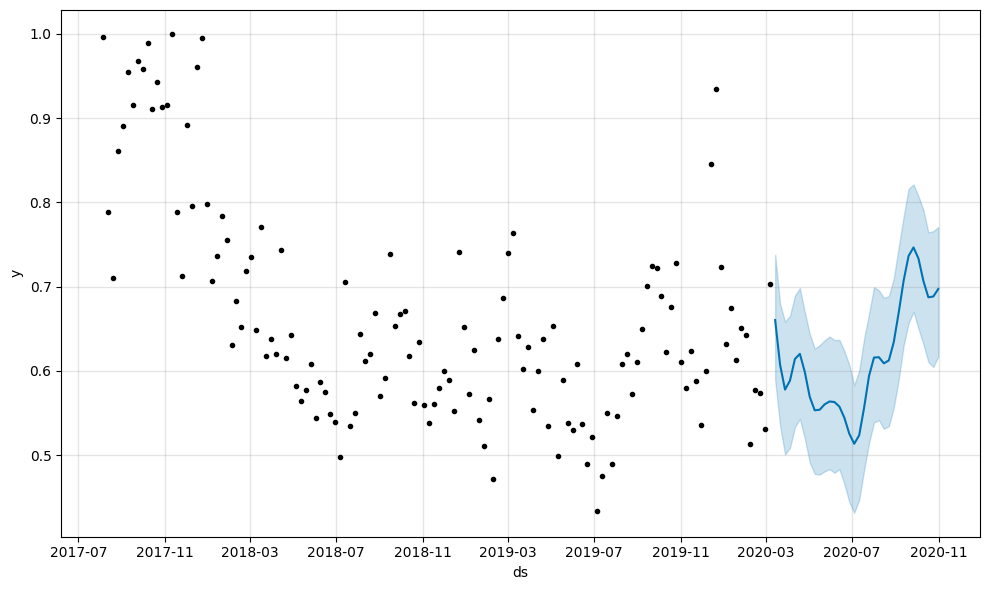

In [115]:
model = Prophet()
model.fit(train_data)
forecast = model.predict(test_data)
fig = model.plot(forecast)
forecast